In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pmdarima as pm
from pmdarima.arima import auto_arima
import re
from statsmodels.tsa.stattools import adfuller


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220526','20220825','20221124','20230223','20230525']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[2]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

1      BME.L
2     BDEV.L
4     BLND.L
5      UTG.L
7      ICP.L
8      DPH.L
10     CCL.L
11    INVP.L
12    WEIR.L
13     BEZ.L
14    ABDN.L
15     IMI.L
16    JMAT.L
18    DPLM.L
19     HSX.L
20     SXS.L
21     IGG.L
22    HWDN.L
23     HIK.L
24    INCH.L
25     ITV.L
26    TATE.L
27    DOCS.L
28     RSW.L
29     DLG.L
30     EZJ.L
31    BBOX.L
32     EMG.L
33     DLN.L
34    DARK.L
Name: Ticker_Symbol, dtype: object

In [14]:
symbols_ = symbols.set_index("Ticker_Symbol")

In [15]:
data = price_volume_data(symbols_short.to_list(),'2017-11-25', '2022-11-29')
data.pv

{'BME.L':                                  Open        High         Low       Close  \
 Date                                                                        
 2017-11-27 00:00:00+00:00  267.015540  268.116639  264.606895  265.501526   
 2017-11-28 00:00:00+00:00  265.501567  266.189752  261.441283  262.886475   
 2017-11-29 00:00:00+00:00  262.886515  266.258616  262.267154  265.088715   
 2017-11-30 00:00:00+00:00  264.951064  265.776894  261.647787  262.817688   
 2017-12-01 00:00:00+00:00  263.643441  266.120909  257.931498  265.501526   
 ...                               ...         ...         ...         ...   
 2022-11-22 00:00:00+00:00  377.587203  389.245766  375.048632  376.929047   
 2022-11-23 00:00:00+00:00  377.023065  389.903915  374.108417  389.245758   
 2022-11-24 00:00:00+00:00  388.681634  393.006592  386.049065  386.331116   
 2022-11-25 00:00:00+00:00  386.801230  386.895257  382.288247  385.861023   
 2022-11-28 00:00:00+00:00  385.578954  388.775653  380

In [19]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short.iloc[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [20]:
df

Ticker_Symbol,BME.L,BDEV.L,BLND.L,UTG.L,ICP.L,DPH.L,CCL.L,INVP.L,WEIR.L,BEZ.L,...,ITV.L,TATE.L,DOCS.L,RSW.L,DLG.L,EZJ.L,BBOX.L,EMG.L,DLN.L,DARK.L
2017-11-27,265.501526,425.623047,471.689545,615.417053,821.791138,2080.190430,4491.983887,269.562531,1754.792358,447.381897,...,109.026268,553.312256,NaN,5086.549805,246.971649,1243.758423,112.871582,141.647324,2311.039307,NaN
2017-11-28,262.886475,421.373901,472.450287,606.516296,830.508362,2107.425537,4534.523926,276.288239,1774.018066,451.341797,...,111.766342,551.256836,NaN,5142.548828,248.424789,1265.310913,111.950798,142.084061,2288.908203,NaN
2017-11-29,265.088715,431.288544,474.732666,608.635620,844.772827,2112.121094,4397.854004,278.440308,1751.296753,449.541840,...,114.217995,549.201538,NaN,5021.218262,252.023193,1263.514893,111.413696,144.704437,2316.146729,NaN
2017-11-30,262.817688,429.164032,478.536621,608.211731,843.980347,2071.738770,4313.680176,278.171326,1714.592896,439.192047,...,115.299591,560.358704,NaN,4960.553711,253.130310,1262.616821,111.183502,144.194946,2364.666260,NaN
2017-12-01,265.501526,425.623047,478.917023,601.430359,826.545898,2016.328735,4311.870605,275.481079,1714.592896,437.302032,...,114.650642,562.856628,NaN,4783.223633,251.054367,1279.679199,109.955803,142.520782,2311.039307,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-22,376.929047,370.149231,384.798615,907.868835,1093.655273,2723.463379,708.000000,466.290771,1763.492065,639.794006,...,69.395103,722.281067,280.909332,3996.005371,220.500000,375.899994,143.760635,202.711212,2319.446289,374.200012
2022-11-23,389.245758,374.791168,389.871643,909.316833,1136.191528,2705.545898,717.000000,473.493256,1784.573608,632.946106,...,70.799110,717.793640,275.145111,4037.837891,220.100006,386.600006,141.565079,203.748825,2331.024414,375.700012
2022-11-24,386.331116,376.183746,392.384460,922.831116,1164.076538,2743.371826,741.000000,476.860626,1773.787720,633.924377,...,72.933189,729.783020,212.699463,4035.845947,222.899994,394.100006,144.619766,205.729721,2371.547119,373.500000
2022-11-25,385.861023,378.319031,392.094513,917.039307,1164.549072,2749.344238,729.799988,475.551086,1777.709961,639.304871,...,73.139114,730.962341,199.441788,4027.877686,223.899994,404.899994,142.519669,203.371521,2383.125000,372.799988


In [21]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file = file.set_index("Unnamed: 0")

In [22]:
file

,Actual Price,Predicted Price,MSE,MAE,R2,Market Share,final_marketcap
Unnamed: 0,,,,,,,
CCL.L,1011.500000,[1102.1017],0.004354,0.065982,1,146260000,"147,941,990,000.00"
PNN.L,921.890503,[978.6994],0.094318,0.307112,1,261327008,240914886834.23047
IGG.L,652.198731,[628.6662],0.035130,0.187431,1,395398016,257878084065.0625
ITV.L,65.962585,[66.964294],0.002242,0.047346,1,4034409984,266120113306.78125
INVP.L,433.472778,[401.9024],0.167294,0.409016,1,645161984,"279,660,157,671.13"
EMG.L,240.397629,[223.5084],0.285668,0.534479,1,1199859968,288443491180.2617
TATE.L,722.515076,[747.0776],0.113386,0.336728,1,401665984,290209728829.28516
RSW.L,4005.439697,[3899.5273],0.019304,0.138940,1,72788496,291549931382.66016
IDS.L,313.700653,[276.65097],0.108747,0.329769,1,956193024,299958376095.6797


In [23]:
########################################

In [24]:
df_standardised = df.iloc[:-3].apply(lambda price: (price.iloc[:-3] - price.iloc[:-3].mean())/price.iloc[:-3].std())
df_standardised




Ticker_Symbol,BME.L,BDEV.L,BLND.L,UTG.L,ICP.L,DPH.L,CCL.L,INVP.L,WEIR.L,BEZ.L,...,ITV.L,TATE.L,DOCS.L,RSW.L,DLG.L,EZJ.L,BBOX.L,EMG.L,DLN.L,DARK.L
2017-11-27,-0.795099,-0.458475,0.408832,-1.923996,-1.120604,-1.202033,1.506144,-0.037464,0.892072,-0.061700,...,0.697703,-1.182332,NaN,0.904174,0.059154,0.901805,-0.845703,-0.112148,-1.488493,NaN
2017-11-28,-0.821266,-0.506853,0.420990,-1.984140,-1.098049,-1.168896,1.536986,0.040175,0.961496,-0.015415,...,0.820860,-1.209859,NaN,0.975953,0.128128,0.961434,-0.871062,-0.101409,-1.550662,NaN
2017-11-29,-0.799230,-0.393971,0.457464,-1.969820,-1.061142,-1.163183,1.437899,0.065018,0.879449,-0.036454,...,0.931053,-1.237383,NaN,0.820433,0.298928,0.956465,-0.885854,-0.036981,-1.474146,NaN
2017-11-30,-0.821954,-0.418160,0.518255,-1.972684,-1.063192,-1.212316,1.376872,0.061913,0.746912,-0.157426,...,0.979667,-1.087965,NaN,0.742673,0.351477,0.953980,-0.892193,-0.049508,-1.337848,NaN
2017-12-01,-0.795099,-0.458475,0.524334,-2.018507,-1.108302,-1.279732,1.375560,0.030858,0.746912,-0.179518,...,0.950499,-1.054513,NaN,0.515373,0.252942,1.001186,-0.926005,-0.090672,-1.488493,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-14,0.293276,-0.994936,-1.149414,0.101066,-0.208084,-0.184414,-1.163779,1.984068,0.765925,1.935734,...,-0.842099,0.581457,-0.556613,-0.531979,-1.762174,-1.374498,-0.026559,1.328957,-1.356463,-0.477695
2022-11-15,0.192988,-1.028760,-1.182442,0.146725,-0.264335,-0.244970,-1.138838,1.902005,0.723437,1.855692,...,-0.950639,0.594521,-0.548298,-0.442611,-1.747935,-1.386394,-0.023929,1.479710,-1.367304,-0.573888
2022-11-16,0.131701,-1.102751,-1.248501,0.032577,-0.343821,-0.385459,-1.223230,1.935479,0.758844,1.621284,...,-1.070959,0.685972,-0.668854,-0.616241,-1.876091,-1.458051,-0.073879,1.347511,-1.508241,-0.628946
2022-11-17,0.183444,-1.121777,-1.131397,0.068452,-0.380506,-0.446015,-1.234105,1.936558,0.767695,1.878561,...,-1.091153,0.876712,-0.602341,-0.634114,-1.676737,-1.463308,-0.047590,1.328957,-1.578711,-0.641603


In [25]:
actual_price_ls = []
ticker_mean_dict = {}
ticker_std_dict = {}
for column in df.columns:
    ticker_mean_dict[column] = df[column].iloc[:-3].mean()
    ticker_std_dict[column] = df[column].iloc[:-3].std()
    actual_price_ls.append((df[column].iloc[-1] - ticker_mean_dict[column]) / ticker_std_dict[column])
actual_price_df = pd.DataFrame(index = df.columns)
actual_price_df["actual_price"] = actual_price_ls


In [26]:
#FINAL

"""
ARIMA & NAIVE


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


import re
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import auto_arima

def find_differencing_order(ts, look_forward):
    d = 0
                                                    
    p_value = adfuller(ts.iloc[:-(look_forward)].dropna())[1]
    while p_value > 0.05:  # Adjust the significance level as needed
        ts_interm = ts.diff().dropna()
        d += 1
        p_value = adfuller(ts_interm)[1]
    return d




####creating a function for ARIMA prediction

def get_ARIMA_PRED(standardised_df, look_forward):
    dict_ = {}
    models = {}  
    results = {}
    
    for column in standardised_df.columns:

        differencing_order = find_differencing_order(standardised_df[column], look_forward)

        best_model = auto_arima(standardised_df[column].iloc[:-(look_forward)].dropna(), start_p=0, d=differencing_order, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=True, trace=True,
                                stepwise=True, suppress_warnings=True, error_action='ignore')



        p_optimal = best_model.get_params()['order'][0]
        d_optimal = best_model.get_params()['order'][1]
        q_optimal = best_model.get_params()['order'][2]

        model_name = re.sub(r'\W+', '_', f'{column}').lower()
        models[model_name] = sm.tsa.ARIMA(standardised_df[column].iloc[:-(look_forward)].dropna(), order=(p_optimal, d_optimal, q_optimal))
        results[model_name] = models[model_name].fit()

        # Print model summary
        print(results[model_name].summary())

        # Plot the residuals to check for randomness
        # Residuals should show no predictability in variance and have a mean of 0
        residuals = results[model_name].resid
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual Value')
        plt.show()

        # Forecast future values
        forecast_steps = look_forward  # Number of time steps to forecast ahead
        forecast = results[model_name].forecast(steps=forecast_steps)

        dict_[column] = {
            "optimal_p": p_optimal,
            "optimal_q": q_optimal,
            "optimal_d": d_optimal,
            "ARIMA_prediction": forecast.iloc[look_forward-1],  # because forecast is a Series with indexing that starts from 0, therefore we subtract 1
        }

    # Create a DataFrame to store the model information
    dict_df = pd.DataFrame(dict_)
    
    return dict_df


#import the price data for the remaining target universe at different rank dates

#dictionary to store DataFrames
dfs_target_uni = {}
params_dict_ = {}

# Loop through each sheet name and read the corresponding sheet into a DataFrame
for date in sheet_name:
    dfs_target_uni[f'df_{sheet_name}'] = pd.read_excel("target_stock_universe.xlsx", sheet_name=date)
    
    params_dict_[date] = get_ARIMA_PRED(df_standardised, 3)
    

sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3259.387, Time=4.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3257.588, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3257.580, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3261.207, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3255.504, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.211 seconds
                               SARIMAX Results                                
Dep. Variable:                  BME.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1631.604
Date:                Mon, 30 Oct 2023   AIC                          -3261.207
Time:                        16:49:54   BIC                          -3256.073
Sample:                             0   HQIC                         -3259.278
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


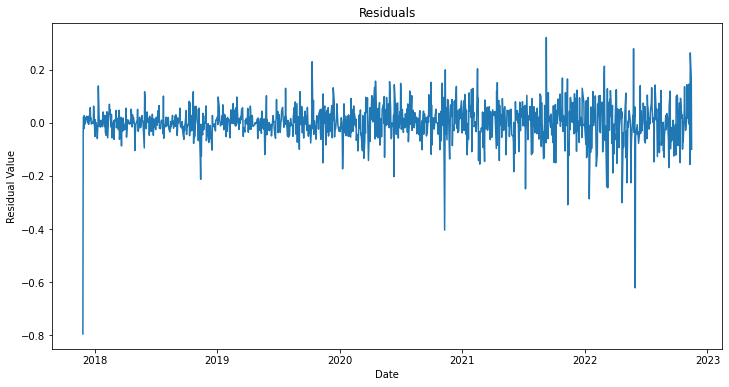

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1746.100, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1745.314, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1745.179, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1748.082, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1745.123, Time=1.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.435 seconds
                               SARIMAX Results                                
Dep. Variable:                 BDEV.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 875.041
Date:                Mon, 30 Oct 2023   AIC                          -1748.082
Time:                        16:49:57   BIC                          -1742.948
Sample:                             0   HQIC                         -1746.152
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


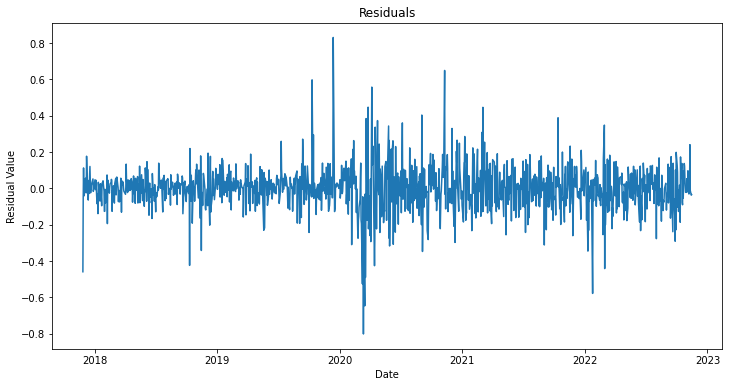

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1542.449, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1540.654, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1540.645, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1544.330, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1538.650, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.096 seconds
                               SARIMAX Results                                
Dep. Variable:                 BLND.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 773.165
Date:                Mon, 30 Oct 2023   AIC                          -1544.330
Time:                        16:49:59   BIC                          -1539.196
Sample:                             0   HQIC                         -1542.401
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


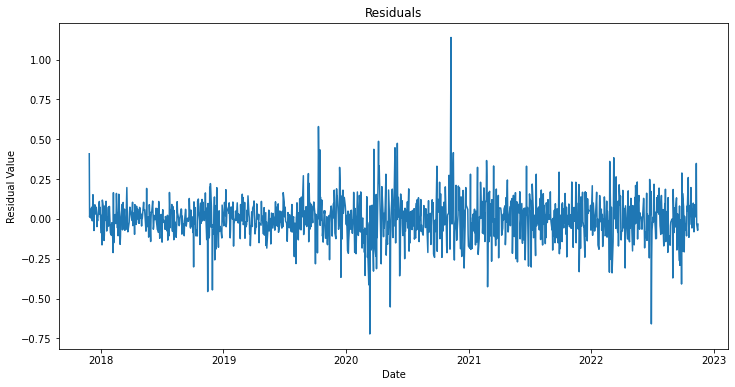

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1881.465, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1889.777, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1888.962, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1883.203, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1889.359, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1888.522, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1888.385, Time=1.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1891.559, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1891.157, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1890.315, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1890.736, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1890.181, Time=0.64 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.090 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


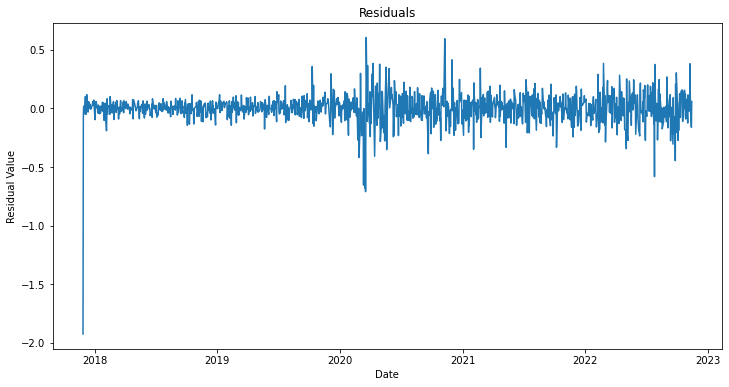

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2738.122, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2736.304, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2736.283, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2740.033, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2736.757, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.608 seconds
                               SARIMAX Results                                
Dep. Variable:                  ICP.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1371.016
Date:                Mon, 30 Oct 2023   AIC                          -2740.033
Time:                        16:50:06   BIC                          -2734.899
Sample:                             0   HQIC                         -2738.103
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


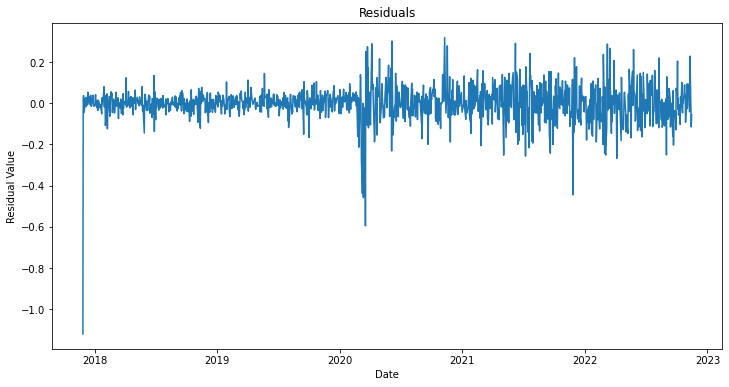

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-856.131, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1074.812, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1119.681, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-858.106, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1117.929, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1117.908, Time=0.82 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1116.100, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1121.565, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1119.816, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1119.795, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1076.752, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1117.986, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.232 seconds
                               SARIMAX Results                                

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


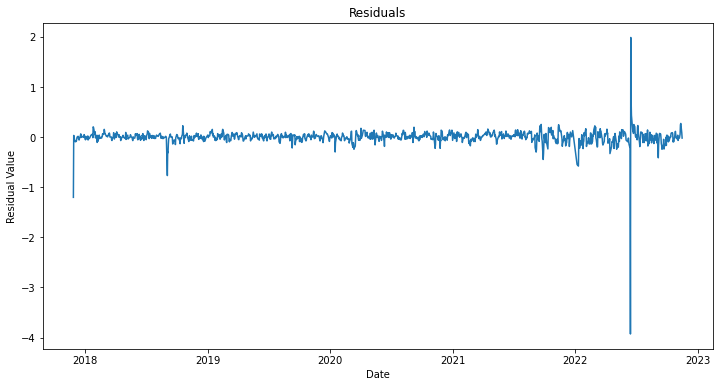

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3947.796, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3947.523, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3947.384, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3947.571, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3945.729, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.965 seconds
                               SARIMAX Results                                
Dep. Variable:                  CCL.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1974.785
Date:                Mon, 30 Oct 2023   AIC                          -3947.571
Time:                        16:50:13   BIC                          -3942.437
Sample:                             0   HQIC                         -3945.641
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


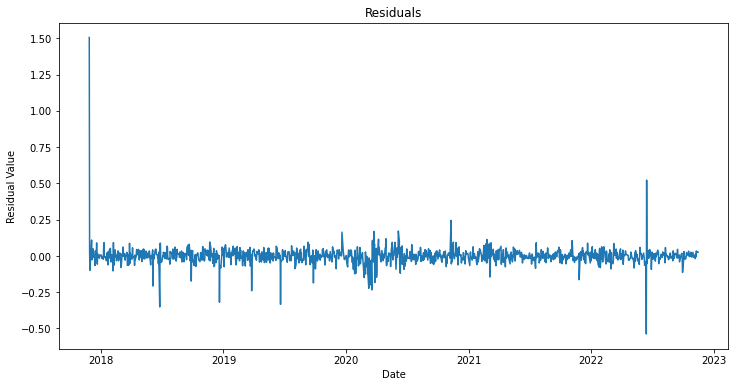

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3069.814, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3067.815, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3067.815, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3071.220, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3071.162, Time=1.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.558 seconds
                               SARIMAX Results                                
Dep. Variable:                 INVP.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1536.610
Date:                Mon, 30 Oct 2023   AIC                          -3071.220
Time:                        16:50:16   BIC                          -3066.085
Sample:                             0   HQIC                         -3069.290
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


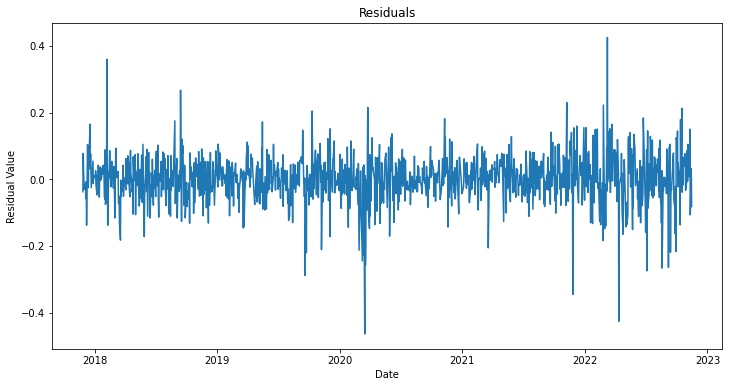

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1631.093, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1629.093, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1629.093, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1633.092, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1627.111, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.024 seconds
                               SARIMAX Results                                
Dep. Variable:                 WEIR.L   No. Observations:                 1254
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 817.546
Date:                Mon, 30 Oct 2023   AIC                          -1633.092
Time:                        16:50:18   BIC                          -1627.958
Sample:                             0   HQIC                         -1631.162
                               - 1254                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


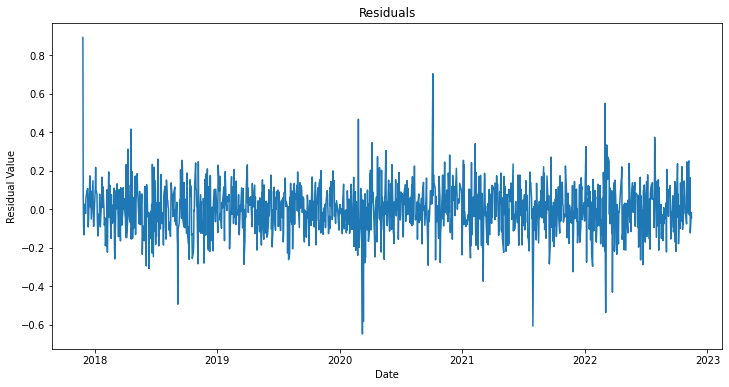

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2047.707, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2046.758, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2046.805, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2049.450, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2050.139, Time=1.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2043.834, Time=1.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2043.789, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2045.314, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2045.394, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2041.388, Time=1.76 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2051.893, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2048.563, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2048.516, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2045.563, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  BEZ.L   No. Observations:                 1255
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1028.946
Date:                Mon, 30 Oct 2023   AIC                          -2051.893
Time:                        16:50:28   BIC                          -2036.490
Sample:                             0   HQIC                         -2046.103
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8850      0.065    -13.579      0.000      -1.013      -0.757
ma.L1          0.9188      0.056     16.328      0.000       0.808       1.029
sigma2         0.0113      0.000     47.766      0.0

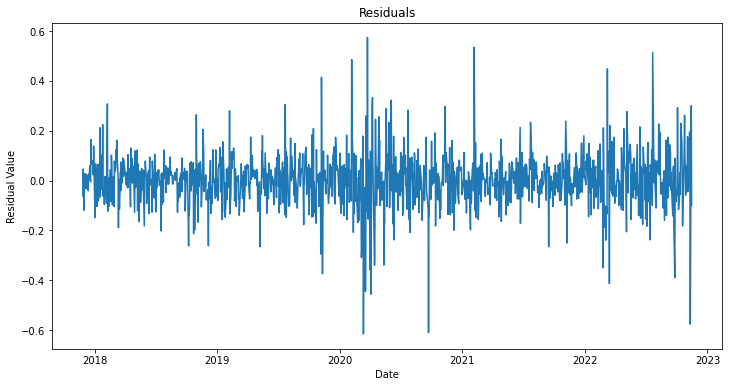

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2043.227, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2041.948, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2041.922, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2044.639, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2039.312, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.422 seconds
                               SARIMAX Results                                
Dep. Variable:                 ABDN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1023.319
Date:                Mon, 30 Oct 2023   AIC                          -2044.639
Time:                        16:50:30   BIC                          -2039.505
Sample:                             0   HQIC                         -2042.709
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


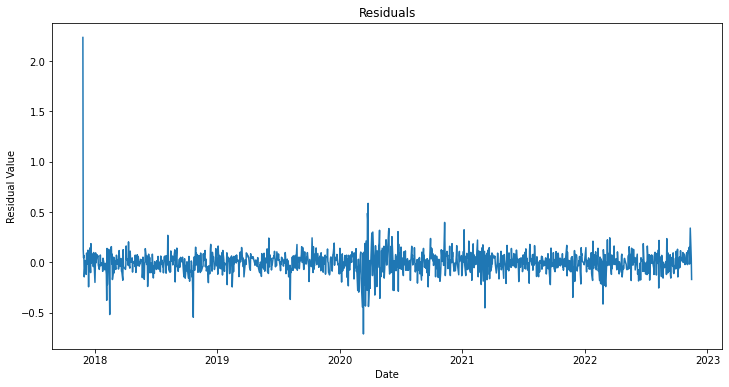

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2979.408, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2977.468, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2977.467, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2981.151, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2975.434, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.435 seconds
                               SARIMAX Results                                
Dep. Variable:                  IMI.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1491.575
Date:                Mon, 30 Oct 2023   AIC                          -2981.151
Time:                        16:50:32   BIC                          -2976.016
Sample:                             0   HQIC                         -2979.221
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


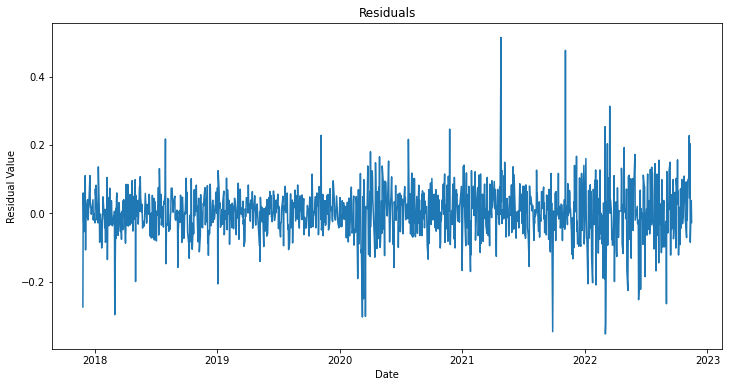

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1877.904, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1877.046, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1877.122, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1879.818, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1876.388, Time=1.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.193 seconds
                               SARIMAX Results                                
Dep. Variable:                 JMAT.L   No. Observations:                 1251
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 940.909
Date:                Mon, 30 Oct 2023   AIC                          -1879.818
Time:                        16:50:35   BIC                          -1874.687
Sample:                             0   HQIC                         -1877.889
                               - 1251                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


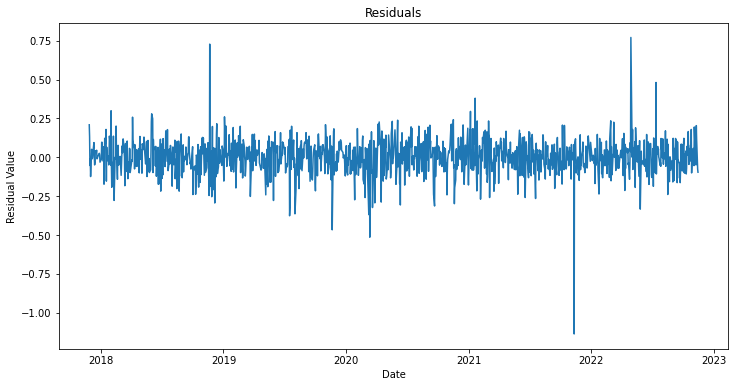

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3367.346, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3366.064, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3366.027, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3368.098, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3364.225, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.508 seconds
                               SARIMAX Results                                
Dep. Variable:                 DPLM.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1685.049
Date:                Mon, 30 Oct 2023   AIC                          -3368.098
Time:                        16:50:37   BIC                          -3362.964
Sample:                             0   HQIC                         -3366.168
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


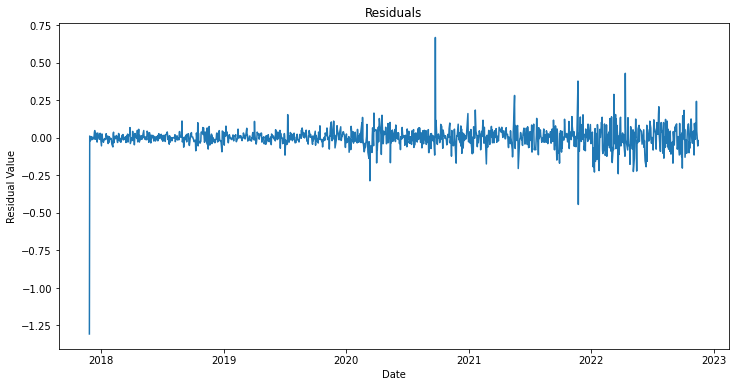

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2923.129, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2922.320, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2922.488, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2924.982, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2923.284, Time=0.96 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.755 seconds
                               SARIMAX Results                                
Dep. Variable:                  HSX.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1463.491
Date:                Mon, 30 Oct 2023   AIC                          -2924.982
Time:                        16:50:39   BIC                          -2919.847
Sample:                             0   HQIC                         -2923.052
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


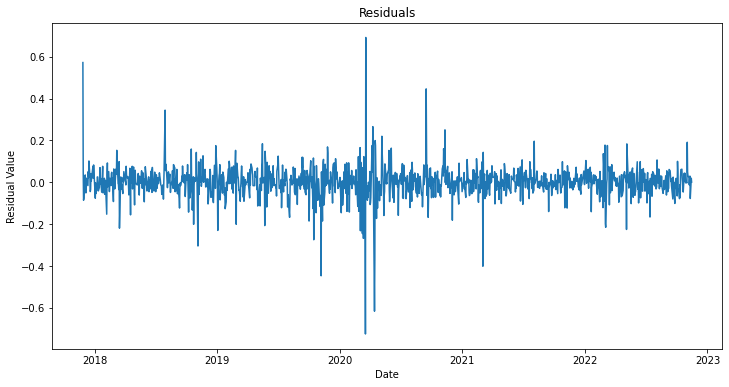

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2449.368, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2453.372, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2453.134, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2450.948, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2451.832, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2451.929, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2449.862, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2454.891, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2453.369, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2453.463, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2454.650, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2451.403, Time=0.63 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.206 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


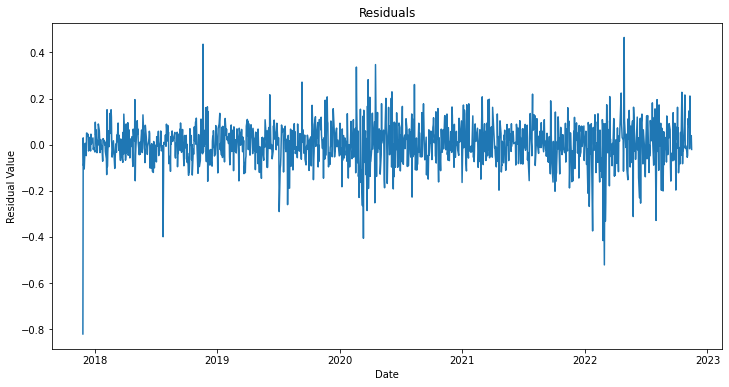

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2543.777, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2547.280, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2547.342, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2545.007, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2545.524, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2545.378, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2543.343, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2548.455, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2546.485, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2546.481, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2548.402, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2544.456, Time=0.34 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.412 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


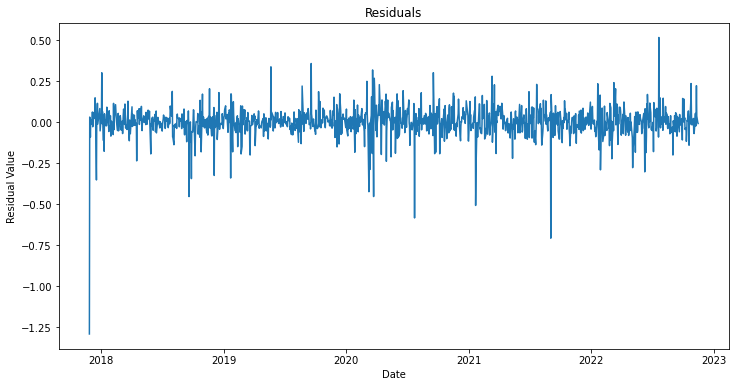

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2967.839, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2968.556, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2968.278, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2969.528, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2967.692, Time=0.82 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.483 seconds
                               SARIMAX Results                                
Dep. Variable:                 HWDN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1485.764
Date:                Mon, 30 Oct 2023   AIC                          -2969.528
Time:                        16:50:50   BIC                          -2964.394
Sample:                             0   HQIC                         -2967.598
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


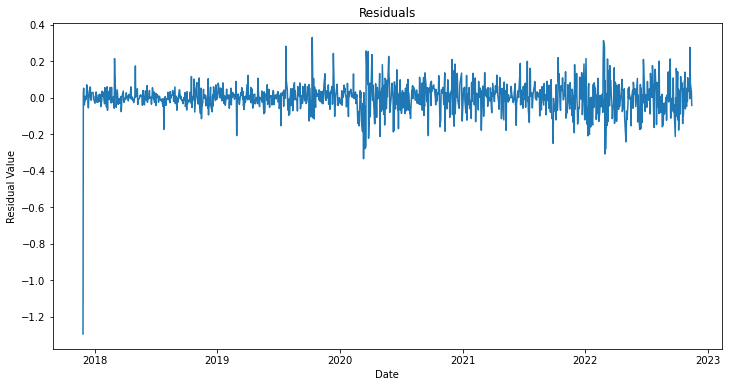

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2724.245, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2723.801, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2723.870, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2726.103, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2722.399, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.911 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HIK.L   No. Observations:                 1254
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1364.052
Date:                Mon, 30 Oct 2023   AIC                          -2726.103
Time:                        16:50:53   BIC                          -2720.970
Sample:                             0   HQIC                         -2724.174
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0066      0.000     43.598      0.000       0.006       0.007
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):               867.30
Prob(Q):                              0.21   Pr

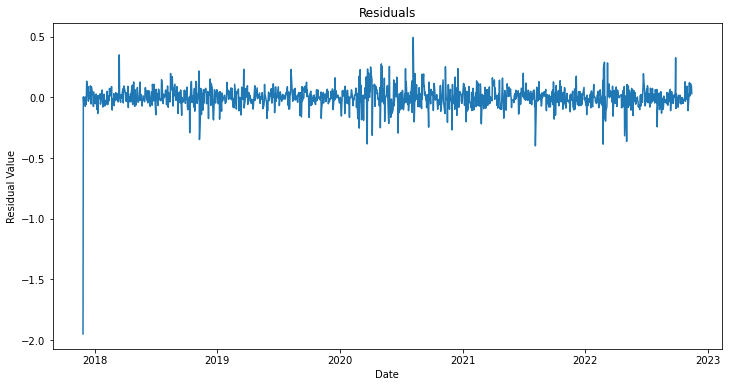

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-94.925, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-308.220, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-378.076, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-96.875, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-376.712, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-376.673, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-374.892, Time=1.49 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-379.828, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-378.454, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-378.416, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-310.106, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-376.078, Time=0.32 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.741 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 INCH.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 191.914
Date:                Mon, 30 Oct 2023   AIC                           -379.828
Time:                        16:50:58   BIC                           -369.560
Sample:                             0   HQIC                          -375.969
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5165      0.003   -178.197      0.000      -0.522      -0.511
sigma2         0.0431      0.000    354.101      0.000       0.043       0.043
Ljung-Box (L1) (Q):                   0.15   Jarque-

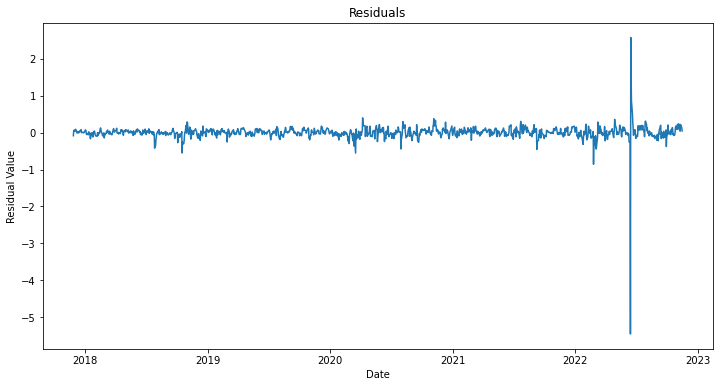

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2244.244, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2242.249, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2242.249, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2246.022, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2240.249, Time=0.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.502 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  ITV.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1124.011
Date:                Mon, 30 Oct 2023   AIC                          -2246.022
Time:                        16:51:00   BIC                          -2240.888
Sample:                             0   HQIC                         -2244.092
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0097      0.000     82.813      0.000       0.010       0.010
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             20866.37
Prob(Q):                              0.94   Pr

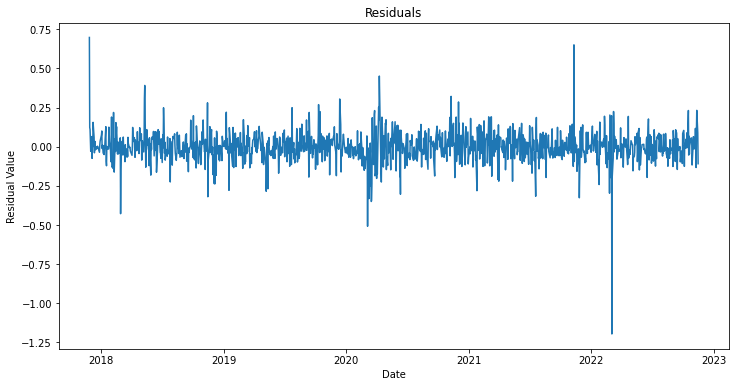

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1679.438, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1678.393, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1678.358, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1681.273, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1676.700, Time=0.73 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.495 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 TATE.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 841.637
Date:                Mon, 30 Oct 2023   AIC                          -1681.273
Time:                        16:51:03   BIC                          -1676.139
Sample:                             0   HQIC                         -1679.343
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0153      0.000     47.172      0.000       0.015       0.016
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):              1358.41
Prob(Q):                              0.33   Pr

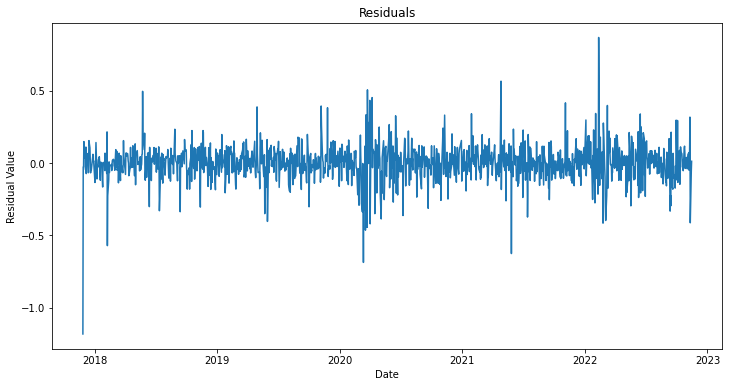

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-848.860, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-846.881, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-846.878, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-850.235, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-845.537, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.686 seconds
                               SARIMAX Results                                
Dep. Variable:                 DOCS.L   No. Observations:                  453
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 426.118
Date:                Mon, 30 Oct 2023   AIC                           -850.235
Time:                        16:51:04   BIC                           -846.121
Sample:                             0   HQIC                          -848.614
                                - 453                                       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


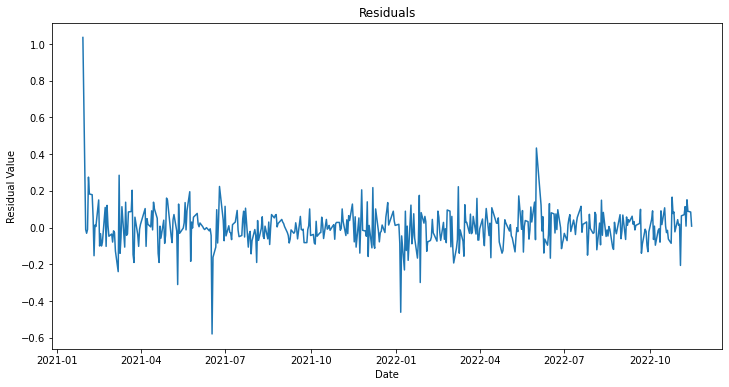

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1435.308, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1433.374, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1433.378, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1437.230, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1435.829, Time=1.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.620 seconds
                               SARIMAX Results                                
Dep. Variable:                  RSW.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 719.615
Date:                Mon, 30 Oct 2023   AIC                          -1437.230
Time:                        16:51:07   BIC                          -1432.096
Sample:                             0   HQIC                         -1435.301
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


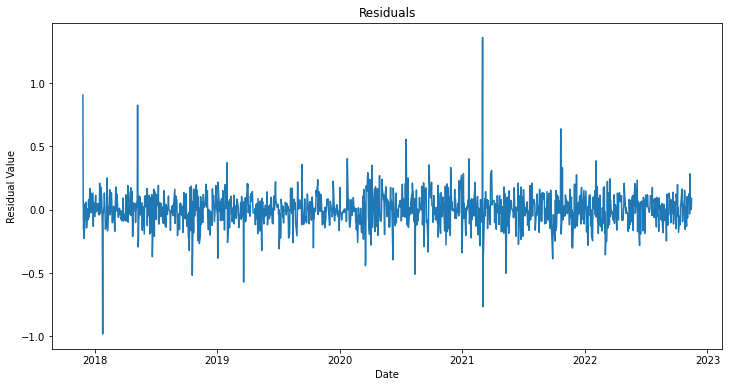

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3556.550, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-614.391, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2134.790, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3554.570, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-616.787, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-619.477, Time=1.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-617.984, Time=0.46 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-617.656, Time=1.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-616.575, Time=2.05 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-625.973, Time=2.21 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-627.871, Time=2.92 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-618.184, Time=2.98 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-626.168, Time=3.37 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-626.156, Time=2.75 sec
 ARIMA(4,0,2)(0,0,0)[0]          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting param

                               SARIMAX Results                                
Dep. Variable:                  DLG.L   No. Observations:                 1254
Model:                 ARIMA(4, 0, 2)   Log Likelihood                 321.821
Date:                Mon, 30 Oct 2023   AIC                           -627.641
Time:                        16:51:40   BIC                           -586.568
Sample:                             0   HQIC                          -612.203
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0977      0.332     -0.294      0.769      -0.749       0.553
ar.L1         -0.3474      0.132     -2.637      0.008      -0.606      -0.089
ar.L2          0.8176      0.060     13.572      0.0

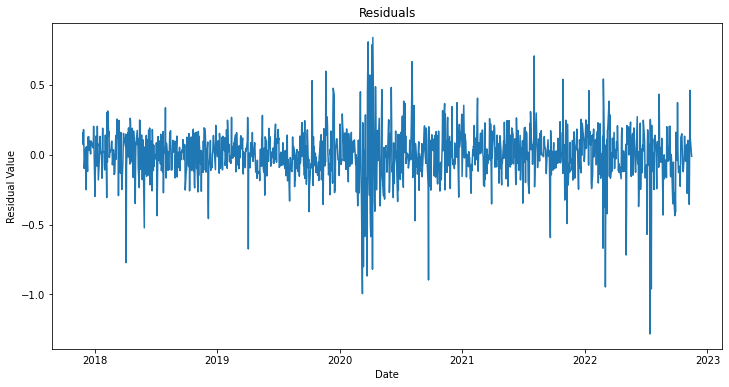

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2906.043, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2907.318, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2906.980, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2907.315, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2909.272, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2907.313, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2907.292, Time=1.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2907.380, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2905.303, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2910.689, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2908.662, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2908.723, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2908.687, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2908.792, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  EZJ.L   No. Observations:                 1254
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1458.344
Date:                Mon, 30 Oct 2023   AIC                          -2910.689
Time:                        16:51:47   BIC                          -2895.289
Sample:                             0   HQIC                         -2904.900
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0488      0.026      1.874      0.061      -0.002       0.100
ar.L2          0.0567      0.020      2.835      0.005       0.017       0.096
sigma2         0.0057      0.000     55.827      0.0

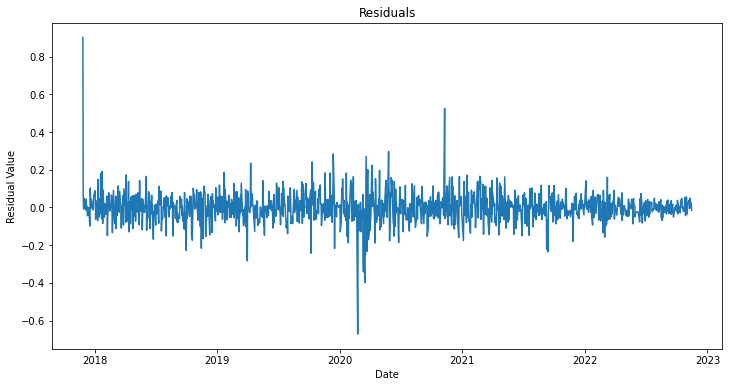

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-517.370, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-763.803, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-863.117, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-519.356, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-862.178, Time=0.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-862.073, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-859.417, Time=1.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-865.009, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-864.064, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-863.960, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-765.768, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-861.309, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.660 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 BBOX.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 434.505
Date:                Mon, 30 Oct 2023   AIC                           -865.009
Time:                        16:51:52   BIC                           -854.741
Sample:                             0   HQIC                          -861.150
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5815      0.003   -190.918      0.000      -0.587      -0.576
sigma2         0.0293    7.2e-05    406.456      0.000       0.029       0.029
Ljung-Box (L1) (Q):                   0.31   Jarque-

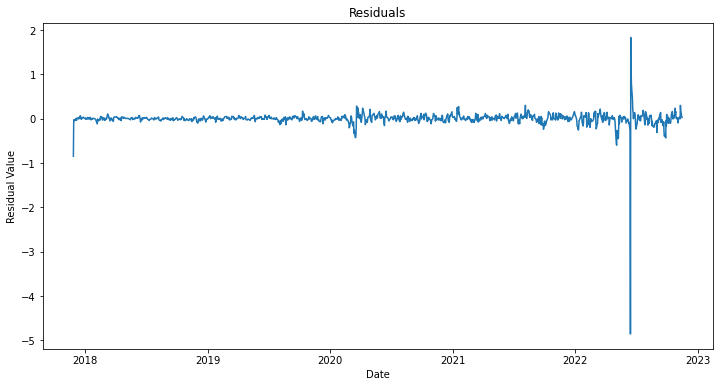

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3020.353, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3021.645, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3021.485, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3021.968, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3019.871, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.428 seconds
                               SARIMAX Results                                
Dep. Variable:                  EMG.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1511.984
Date:                Mon, 30 Oct 2023   AIC                          -3021.968
Time:                        16:51:54   BIC                          -3016.834
Sample:                             0   HQIC                         -3020.038
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


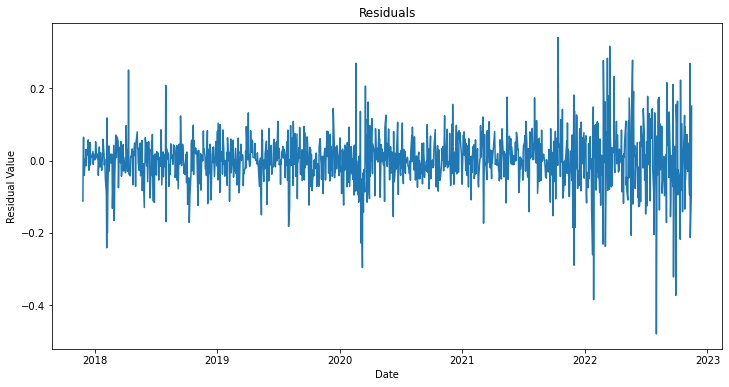

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1485.090, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1483.147, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1483.139, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1487.090, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1482.743, Time=1.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.174 seconds
                               SARIMAX Results                                
Dep. Variable:                  DLN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 744.545
Date:                Mon, 30 Oct 2023   AIC                          -1487.090
Time:                        16:51:57   BIC                          -1481.956
Sample:                             0   HQIC                         -1485.160
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


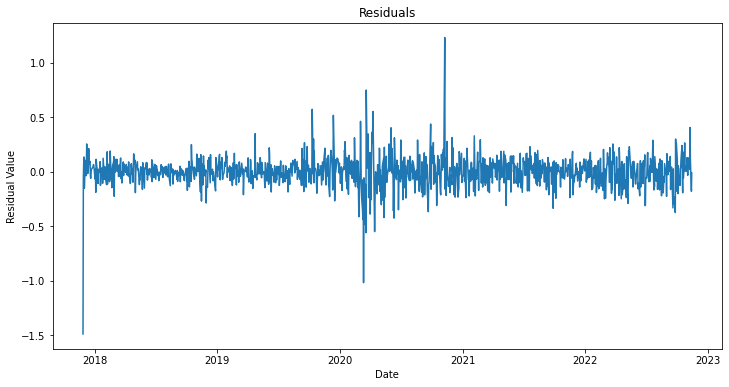

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-275.099, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-275.238, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-275.449, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-277.090, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-275.179, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.898 seconds
                               SARIMAX Results                                
Dep. Variable:                 DARK.L   No. Observations:                  386
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 139.545
Date:                Mon, 30 Oct 2023   AIC                           -277.090
Time:                        16:51:58   BIC                           -273.136
Sample:                             0   HQIC                          -275.522
                                - 386                                       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


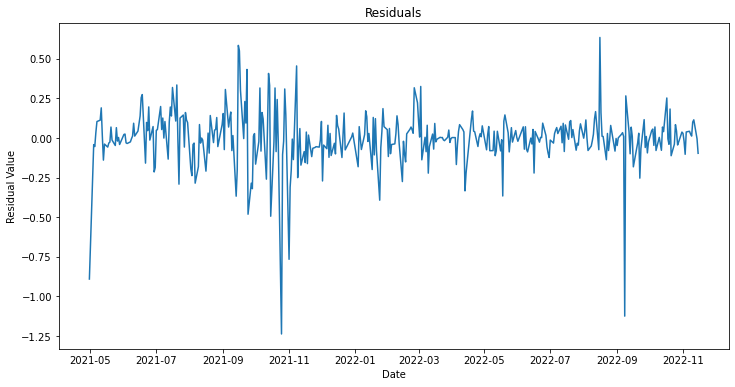

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
look_forward = 3
dict_df = get_ARIMA_PRED(df_standardised, look_forward)

In [28]:
dict_df_T = dict_df.T


In [29]:
###############################


#PRODUCE NAIVE PREDICTION
naive_predictions = []
for column in df_standardised.columns:
    naive_predictions.append(df_standardised[column].iloc[-4])
dict_df_T["naive_prediction"] = naive_predictions


In [30]:
#verifying that the naive prediction is identical with the actual price.iloc[-4]

df_standardised.iloc[-4] == dict_df_T["naive_prediction"]

Ticker_Symbol
BME.L     True
BDEV.L    True
BLND.L    True
UTG.L     True
ICP.L     True
DPH.L     True
CCL.L     True
INVP.L    True
WEIR.L    True
BEZ.L     True
ABDN.L    True
IMI.L     True
JMAT.L    True
DPLM.L    True
HSX.L     True
SXS.L     True
IGG.L     True
HWDN.L    True
HIK.L     True
INCH.L    True
ITV.L     True
TATE.L    True
DOCS.L    True
RSW.L     True
DLG.L     True
EZJ.L     True
BBOX.L    True
EMG.L     True
DLN.L     True
DARK.L    True
dtype: bool

In [31]:
dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]

BME.L     False
BDEV.L     True
BLND.L     True
UTG.L     False
ICP.L      True
DPH.L     False
CCL.L      True
INVP.L     True
WEIR.L     True
BEZ.L     False
ABDN.L    False
IMI.L      True
JMAT.L     True
DPLM.L     True
HSX.L      True
SXS.L     False
IGG.L     False
HWDN.L     True
HIK.L      True
INCH.L    False
ITV.L      True
TATE.L     True
DOCS.L     True
RSW.L     False
DLG.L     False
EZJ.L     False
BBOX.L    False
EMG.L      True
DLN.L      True
DARK.L     True
dtype: bool

In [32]:
(dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]).value_counts()

True     18
False    12
Name: count, dtype: int64

In [33]:
param_df = dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]
param_df

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
BME.L,0.0,0.0,1.0,0.192988,0.192988
UTG.L,1.0,0.0,1.0,0.151277,0.146725
DPH.L,0.0,1.0,1.0,-0.235495,-0.244970
BEZ.L,1.0,1.0,1.0,1.838490,1.855692
ABDN.L,0.0,0.0,1.0,-0.671744,-0.671744
SXS.L,1.0,0.0,1.0,1.267911,1.266401
IGG.L,0.0,1.0,1.0,1.431483,1.430973
INCH.L,0.0,1.0,1.0,1.730591,1.754434
RSW.L,0.0,0.0,1.0,-0.442611,-0.442611
DLG.L,4.0,2.0,0.0,-1.672274,-1.747935


In [34]:
#create a new dataframe for comparison of analysis

comparision_df = pd.DataFrame(index = param_df.index)

In [35]:
#file["Actual Price"].index = dict_df_T.index.to_list()
comparision_df["ARIMA_prediction"]=param_df["ARIMA_prediction"]
comparision_df["naive_prediction"]=param_df["naive_prediction"]

In [36]:
comparision_df["Actual Price, y"] = actual_price_df.loc[comparision_df.index].values 


In [37]:
comparision_df["SE_ARIMA"] =\
(
    np.square(comparision_df["ARIMA_prediction"].values - comparision_df["Actual Price, y"].values) 
)

comparision_df["SE_naive"] =\
(
    np.square(comparision_df["naive_prediction"].values - actual_price_df["actual_price"].loc[param_df.index].values)
)
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BME.L,0.192988,0.192988,0.403145,0.044166,0.044166
UTG.L,0.151277,0.146725,0.127126,0.000583,0.000384
DPH.L,-0.235495,-0.244970,-0.416350,0.032709,0.029371
BEZ.L,1.838490,1.855692,2.070755,0.053947,0.046252
ABDN.L,-0.671744,-0.671744,-0.457220,0.046020,0.046020
SXS.L,1.267911,1.266401,1.326501,0.003433,0.003612
IGG.L,1.431483,1.430973,1.505466,0.005473,0.005549
INCH.L,1.730591,1.754434,1.744268,0.000187,0.000103
RSW.L,-0.442611,-0.442611,-0.515941,0.005377,0.005377
DLG.L,-1.672274,-1.747935,-1.421309,0.062983,0.106684


In [38]:
dict_df_T["Actual Price, y"] = actual_price_df.loc[dict_df_T.index].values


In [39]:
dict_df_T["SE_ARIMA"] =\
(
    np.square(dict_df_T["ARIMA_prediction"].values - dict_df_T["Actual Price, y"].values) 
)

dict_df_T["SE_naive"] =\
(
    np.square(dict_df_T["naive_prediction"].values - dict_df_T["Actual Price, y"].values)
)
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BME.L,0.0,0.0,1.0,0.192988,0.192988,0.403145,0.044166,0.044166
BDEV.L,0.0,0.0,1.0,-1.028760,-1.028760,-1.074666,0.002107,0.002107
BLND.L,0.0,0.0,1.0,-1.182442,-1.182442,-0.882578,0.089919,0.089919
UTG.L,1.0,0.0,1.0,0.151277,0.146725,0.127126,0.000583,0.000384
ICP.L,0.0,0.0,1.0,-0.264335,-0.264335,-0.305352,0.001682,0.001682
DPH.L,0.0,1.0,1.0,-0.235495,-0.244970,-0.416350,0.032709,0.029371
CCL.L,0.0,0.0,1.0,-1.138838,-1.138838,-1.232712,0.008812,0.008812
INVP.L,0.0,0.0,1.0,1.902005,1.902005,2.317408,0.172560,0.172560
WEIR.L,0.0,0.0,1.0,0.723437,0.723437,0.940968,0.047320,0.047320
BEZ.L,1.0,1.0,1.0,1.838490,1.855692,2.070755,0.053947,0.046252


In [40]:
#market share extraction. market share on rank date strictly

tickers = symbols_short

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )


result_ = extract_sp(tickers,start="2022-11-28", end="2022-11-29")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df_strict =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='last')

)

market_share_df_strict

,Company,Date,Market Share
22,HWDN.L,2022-11-30 00:00:00+00:00,559372032
34,DLN.L,2022-11-30 00:00:00+00:00,113323000
31,BBOX.L,2022-11-29 00:00:00+00:00,1895670016
33,EMG.L,2022-11-29 00:00:00+00:00,1298680064
29,DLG.L,2022-11-29 00:00:00+00:00,1338150016
28,RSW.L,2022-11-29 00:00:00+00:00,73882000
35,DARK.L,2022-11-29 00:00:00+00:00,747248000
24,INCH.L,2022-11-29 00:00:00+00:00,388019008
23,HIK.L,2022-11-29 00:00:00+00:00,221034000
0,BME.L,2022-11-29 00:00:00+00:00,1012120000


In [41]:
### market share NEAR rank date

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )

#tickers = ['AAPL','MSFT']

tickers = symbols_short

result_ = extract_sp(tickers,start="2015-11-25", end="2022-11-29")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='first')

)

market_share_df

,Company,Date,Market Share
8986,DARK.L,2022-11-30 00:00:00+00:00,723027008
207,BME.L,2022-11-30 00:00:00+00:00,1009900032
7830,BBOX.L,2022-11-30 00:00:00+00:00,1894370048
4130,DPLM.L,2022-11-30 00:00:00+00:00,129210000
6866,DOCS.L,2022-11-30 00:00:00+00:00,1500349952
5477,HWDN.L,2022-11-30 00:00:00+00:00,559372032
2842,WEIR.L,2022-11-30 00:00:00+00:00,259968992
3244,BEZ.L,2022-11-30 00:00:00+00:00,671161024
896,BLND.L,2022-11-30 00:00:00+00:00,950611008
7446,DLG.L,2022-11-30 00:00:00+00:00,1355110016


In [42]:
#checking for stock that doesnt have market share extracted


dict_df_T.index[~dict_df_T.index.isin(market_share_df["Company"].to_list())]

Index([], dtype='object')

In [43]:
market_share_df_ = market_share_df.set_index("Company")
ordered_market_share_df = market_share_df_.loc[dict_df_T.index]
ordered_market_share_df

,Date,Market Share
BME.L,2022-11-30 00:00:00+00:00,1009900032
BDEV.L,2022-11-30 00:00:00+00:00,1016940032
BLND.L,2022-11-30 00:00:00+00:00,950611008
UTG.L,2022-11-27 00:00:00+00:00,400233984
ICP.L,2022-11-26 00:00:00+00:00,284867008
DPH.L,2022-11-09 00:00:00+00:00,113825000
CCL.L,2022-11-30 00:00:00+00:00,1318610048
INVP.L,2022-11-17 00:00:00+00:00,696083008
WEIR.L,2022-11-30 00:00:00+00:00,259968992
BEZ.L,2022-11-30 00:00:00+00:00,671161024


In [44]:
#un-normalise the actual_price
ticker_mean_df = pd.Series(ticker_mean_dict.values(), index = ticker_mean_dict.keys())
ticker_std_df = pd.Series(ticker_std_dict.values(), index = ticker_std_dict.keys())

dict_df_T["un-normalised_actual_mrkt_share"] = pd.Series((actual_price_df.values.flatten() * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_ARIMA_pred_mrkt_share"] = pd.Series((dict_df_T["ARIMA_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_naive_pred_mrkt_share"] = pd.Series((dict_df_T["naive_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
result = dict_df_T[["un-normalised_actual_mrkt_share", "un-normalised_ARIMA_pred_mrkt_share", "un-normalised_naive_pred_mrkt_share"]].mul(ordered_market_share_df["Market Share"], axis=0)
result.head(3)


,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share
BME.L,3.891113e+11,3.679225e+11,3.679225e+11
BDEV.L,3.775525e+11,3.816534e+11,3.816534e+11
BLND.L,3.714431e+11,3.536075e+11,3.536075e+11


In [45]:
symbols['Ticker'] = symbols['Ticker'].str.split(' ').str[0]
symbols['Ticker'] = symbols['Ticker'] + ".L"
symbols.head(3)

,Ticker,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
1,BME.L,B&M European Value Retail SA,0.193554,931.245885,400.9,4016431616,BMTRW10,LU1072616219,FTSE100,BME.L
2,BDEV.L,Barratt Developments PLC,0.209897,1015.446391,398.7,3999239936,0081180,GB0000811801,FTSE100,BDEV.L
4,BLND.L,British Land Co PLC/The,0.196217,924.007102,409.6,3797062656,0136701,GB0001367019,FTSE100,BLND.L


In [57]:
#result is the prediction results
result2 = result.reset_index().rename(columns = {"index": "Ticker"})
merged = result2.merge(symbols, how='left', on='Ticker') #target universe is list before rank date
merged.head(3)

,Ticker,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,BME.L,3.891113e+11,3.679225e+11,3.679225e+11,B&M European Value Retail SA,0.193554,931.245885,400.9,4016431616,BMTRW10,LU1072616219,FTSE100,BME.L
1,BDEV.L,3.775525e+11,3.816534e+11,3.816534e+11,Barratt Developments PLC,0.209897,1015.446391,398.7,3999239936,0081180,GB0000811801,FTSE100,BDEV.L
2,BLND.L,3.714431e+11,3.536075e+11,3.536075e+11,British Land Co PLC/The,0.196217,924.007102,409.6,3797062656,0136701,GB0001367019,FTSE100,BLND.L


In [58]:
## 90percentile decision module + confusion matrix 

In [59]:
#this is the decision module
def get_top10(merged_df, column):
    merged_df2 = merged_df.sort_values(by=column, ascending = False).reset_index(drop=True)
    ftse_250 = merged_df2[merged_df2["Index"] =='FTSE250']
    ftse_100 = merged_df2[merged_df2["Index"] =='FTSE100']

    # list of stocks that is going into FTSE100
    stocks_into_FTSE100 = ftse_250[ftse_250.index<ftse_100.index[0]]['Ticker'].to_list()

    # number of stocks that is going into FTSE100
    number_of_stocks = len(stocks_into_FTSE100)

    # list of stocks that is going out from FTSE100
    stocks_out_from_FTSE100 = ftse_100['Ticker'].tail(number_of_stocks).to_list()
    
    return stocks_into_FTSE100, stocks_out_from_FTSE100

stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive = get_top10(merged, "un-normalised_naive_pred_mrkt_share")
stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA = get_top10(merged, "un-normalised_ARIMA_pred_mrkt_share")


date = "2022-12-19"

def confusion_matrix(stocks_into_FTSE100, stocks_out_from_FTSE100, date):
    post_rebalancing = pd.read_csv("ftse100_rebalancing_summary.csv")
    post_rebalancing_ = post_rebalancing[post_rebalancing["Post Date"] ==  date]
    
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"

    true_positive_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == -1.0]["Ticker"]
    )
    true_negative_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == 1.0]["Ticker"]
    )
#     true_positive_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == 1.0]["Ticker"]
#     )
#     true_negative_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == -1.0]["Ticker"]
#     )
    
    true_positive_count = 0
    true_negative_count = 0
    
    for outgoing in stocks_out_from_FTSE100:
        if true_positive_100.isin([outgoing]).any():
            true_positive_count+=1
    
    for incoming in stocks_into_FTSE100:
        if true_negative_100.isin([incoming]).any():
            true_negative_count+=1
            
    #reconfirm the top10 predicted
    going_up_length = len(stocks_into_FTSE100)

    retained_in_top10 = list(symbols["Ticker"].iloc[:10 - going_up_length].values)
    retained_in_top10.extend(stocks_into_FTSE100)

    #reconfirm the bottom 25 predicted
    coming_down_length = len(stocks_out_from_FTSE100)

    retained_in_bottom25 = list(symbols["Ticker"].iloc[(10 + coming_down_length):].values)
    retained_in_bottom25.extend(stocks_into_FTSE100)
    
    
#     true_positive = true_positive_count / len(retained_in_top10 + retained_in_bottom25)
#     false_positive = (len(retained_in_top10)-true_positive_count) / len(retained_in_top10 + retained_in_bottom25)
#     true_negative = true_negative_count / len(retained_in_top10 + retained_in_bottom25)
#     false_negative = (len(retained_in_bottom25)-true_negative_count) / len(retained_in_top10 + retained_in_bottom25)
    
    true_positive = true_positive_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_positive = (len(stocks_out_from_FTSE100) - true_positive_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    true_negative = true_negative_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_negative = (len(stocks_into_FTSE100) - true_negative_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    
    #can return retained_in_top10 and retained_in_bottom25 to know the ordered prediction of top10&bottom25 if we want
    return true_positive, false_positive, true_negative, false_negative
    

In [60]:
true_positive_naive, false_positive_naive, true_negative_naive, false_negative_naive = confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive, date)
true_positive_ARIMA, false_positive_ARIMA, true_negative_ARIMA, false_negative_ARIMA = confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA, date)

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5807/1399600058.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5807/1399600058.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5807/1399600058.py:28: SettingWithCopyWarning: 
A va

In [61]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive,date))

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5807/1399600058.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5807/1399600058.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"


1.0

In [62]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA,date))

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5807/1399600058.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_5807/1399600058.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"


1.0

In [63]:
print("Percentage of true positive in naive model is {:.3f}%".format(true_positive_naive*100))
print("Percentage of true negative in naive model is {:.3f}%".format(true_negative_naive*100))
print("Percentage of false positive in naive model is {:.3f}%".format(false_positive_naive*100))
print("Percentage of false negative in naive model is {:.3f}%".format(false_negative_naive*100))

Percentage of true positive in naive model is 25.000%
Percentage of true negative in naive model is 25.000%
Percentage of false positive in naive model is 25.000%
Percentage of false negative in naive model is 25.000%


In [64]:
print("Percentage of true positive in ARIMA model is {:.3f}%".format(true_positive_ARIMA*100))
print("Percentage of true negative in ARIMA model is {:.3f}%".format(true_negative_ARIMA*100))
print("Percentage of false positive in ARIMA model is {:.3f}%".format(false_positive_ARIMA*100))
print("Percentage of false negative in ARIMA model is {:.3f}%".format(false_negative_ARIMA*100))

Percentage of true positive in ARIMA model is 25.000%
Percentage of true negative in ARIMA model is 25.000%
Percentage of false positive in ARIMA model is 25.000%
Percentage of false negative in ARIMA model is 25.000%


In [65]:
#param_df shows us the parameters that gave different ARIMA and Naive predictions

In [66]:
#same false positive between ARIMA and NAIVE.